# House Price Prediction

In [1]:
# import all required modules
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from pyspark import SparkContext
from  pyspark.sql  import SQLContext
from pyspark.sql.functions import mean, min, max, avg, stddev, desc, isnull, col, log, lit
from pyspark.mllib.stat import Statistics
from pyspark.sql.types import DoubleType

# Creating sql context and reading data with spark sql

In [2]:
sc = SparkContext('local', 'Spark SQL')
sqlContext = SQLContext(sc)

df = sqlContext.read.format("com.databricks.spark.csv").options(delimiter=',', header = True, inferSchema = True
                                                               ).load('Data.csv')

In [3]:
df.printSchema()

root
 |-- id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- price: decimal(7,0) (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- sqft_living: integer (nullable = true)
 |-- sqft_lot: integer (nullable = true)
 |-- floors: double (nullable = true)
 |-- waterfront: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- condition: integer (nullable = true)
 |-- grade: integer (nullable = true)
 |-- sqft_above: integer (nullable = true)
 |-- sqft_basement: integer (nullable = true)
 |-- yr_built: integer (nullable = true)
 |-- yr_renovated: integer (nullable = true)
 |-- zipcode: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- sqft_living15: integer (nullable = true)
 |-- sqft_lot15: integer (nullable = true)



# change the datatype of price from decimal to double

In [4]:
df_new = df.withColumn("price", df["price"].cast(DoubleType()))
df_new.printSchema()


root
 |-- id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- price: double (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- sqft_living: integer (nullable = true)
 |-- sqft_lot: integer (nullable = true)
 |-- floors: double (nullable = true)
 |-- waterfront: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- condition: integer (nullable = true)
 |-- grade: integer (nullable = true)
 |-- sqft_above: integer (nullable = true)
 |-- sqft_basement: integer (nullable = true)
 |-- yr_built: integer (nullable = true)
 |-- yr_renovated: integer (nullable = true)
 |-- zipcode: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- sqft_living15: integer (nullable = true)
 |-- sqft_lot15: integer (nullable = true)



In [5]:
# cache the dataset
df_new.cache()

DataFrame[id: bigint, date: string, price: double, bedrooms: int, bathrooms: double, sqft_living: int, sqft_lot: int, floors: double, waterfront: int, view: int, condition: int, grade: int, sqft_above: int, sqft_basement: int, yr_built: int, yr_renovated: int, zipcode: int, lat: double, long: double, sqft_living15: int, sqft_lot15: int]

# Exploratory Data Analysis 

In [6]:
df_new.select([max('price'), mean('price'), min('price')] ).show()

+----------+-----------------+----------+
|max(price)|       avg(price)|min(price)|
+----------+-----------------+----------+
| 7700000.0|540088.1417665294|   75000.0|
+----------+-----------------+----------+



# Plot a distribution and box plot for the price variable. Find out if there are any outliersand list them.

C:\ProgramData\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


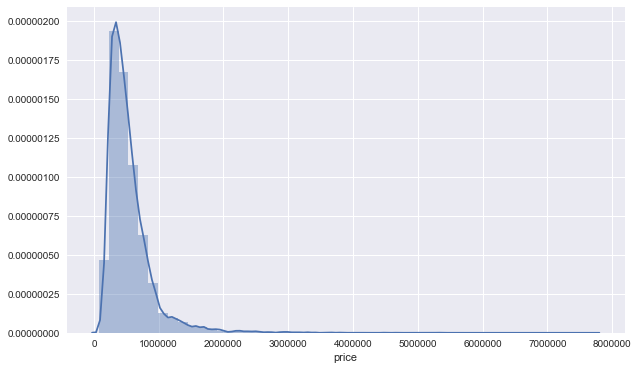

In [7]:
price_pandas_df = df_new.select('price').toPandas()

sn.set(rc={"figure.figsize": (10, 6)})

sn.distplot(price_pandas_df['price'], norm_hist=True)

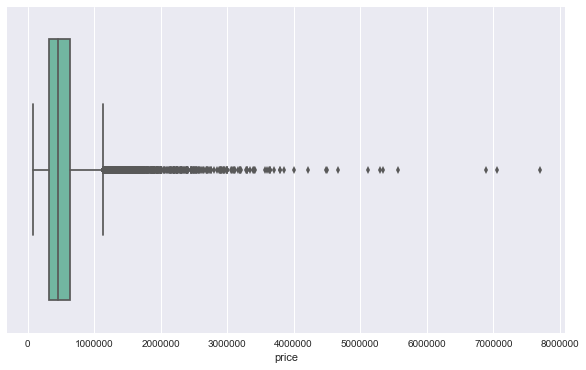

In [8]:
sn.boxplot(x= price_pandas_df['price'], palette="Set2")

# Here we can see there are many outliers in dataset. 
 We consider all those points as outliers which are outside mean +- 2(std dev).

# Find out which variables are highly correlated with price.

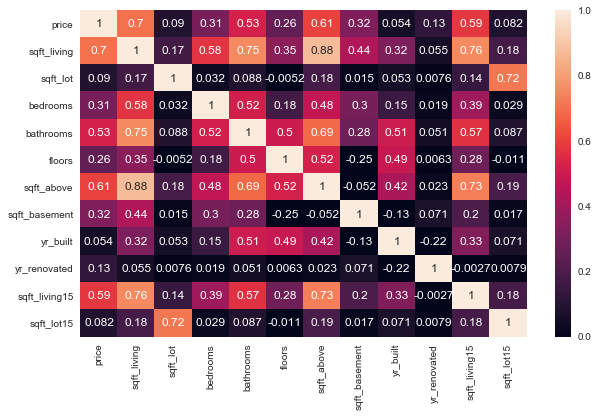

In [9]:
# defining label and finding corelation
labels  = ['price','sqft_living', 'sqft_lot', 'bedrooms','bathrooms', 'floors', 'sqft_above', 
                  'sqft_basement','yr_built','yr_renovated', 'sqft_living15', 'sqft_lot15']

corr_df = Statistics.corr(df_new.rdd.map(lambda x: np.array([x['price'], x['sqft_living'], x['sqft_lot'],
                                                                        x['bedrooms'], x['bathrooms'], x['floors'],
                                                                        x['sqft_above'], x['sqft_basement'], x['yr_built'],
                                                                        x['yr_renovated'], x['sqft_living15'], x['sqft_lot15']
                                                                       ])), method='pearson')


sn.heatmap( corr_df, vmin=0, vmax=1, annot= True, xticklabels = labels, yticklabels = labels)

# The factors sqft_living, number of bathrooms, sqft_living15 and sqft_above seem to be highly correlated with price and can be good predictors for price

# Find out which zip codes have the highest median house price. Do a bar plot to depict the top 10.

In [10]:
zipcode_df = df_new.groupBy('zipcode').agg(avg('price')).sort( desc( 'avg(price)') )
zipcode_df.toPandas()[0:10]

,zipcode,avg(price)
0,98039,2.160607e+06
1,98004,1.355927e+06
2,98040,1.194230e+06
3,98112,1.095499e+06
4,98102,9.012583e+05
5,98109,8.796236e+05
6,98105,8.628252e+05
7,98006,8.596848e+05
8,98119,8.494480e+05
9,98005,8.101649e+05


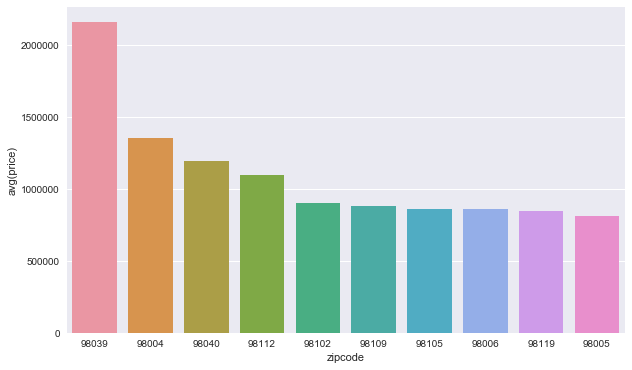

In [11]:
top_10 = zipcode_df.toPandas()[0:10]
sn.barplot( data = top_10, x='zipcode', y='avg(price)', order = top_10.zipcode)

# Find out if there are any missing values in the dataset and your strategy for imputing those.

In [12]:
df_clean = df_new.na.drop( how = 'any' )
df_clean.count() == df_new.count()

True

# Do some variables need feature engineering or transformation, if they need to be used to predict prices. Explain what transformations you will apply.

# Here as we already seen price data is right skewed. 
# We can apply log transformation to make it normally distributed.

C:\ProgramData\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


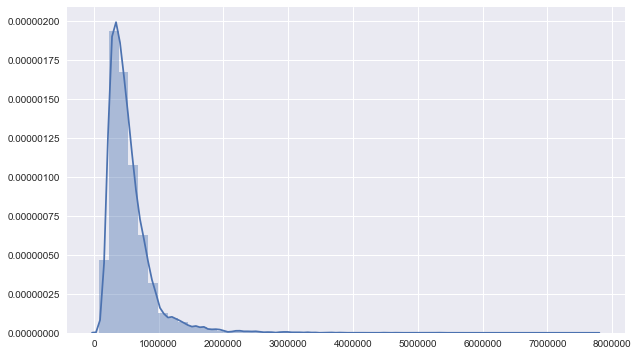

In [13]:
sn.set(rc={"figure.figsize": (10, 6)})
sn.distplot(price_pandas_df, norm_hist=True)

C:\ProgramData\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


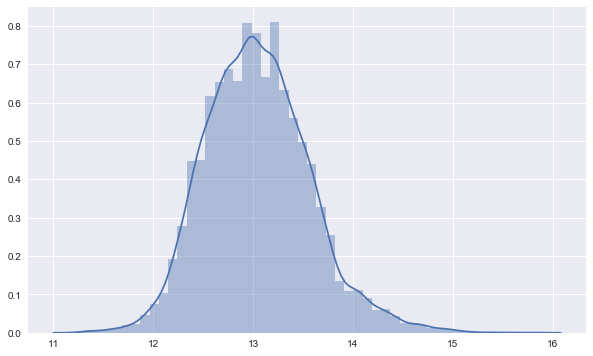

In [14]:
# apply log transformation to make it normally distributed
df_new = df_new.withColumn( 'log_price', log('price') )

sn.set(rc={"figure.figsize": (10, 6)})
sn.distplot(df_new.select('log_price').toPandas(), norm_hist=True)

C:\ProgramData\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


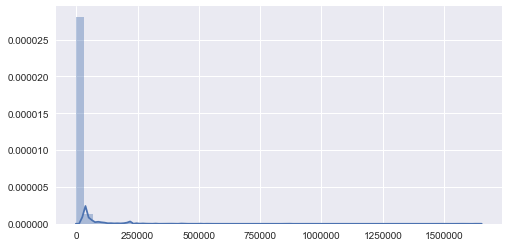

In [15]:
sn.set(rc={"figure.figsize": (8, 4)})
sn.distplot(df_new.select('sqft_lot').toPandas(), norm_hist=True)

C:\ProgramData\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


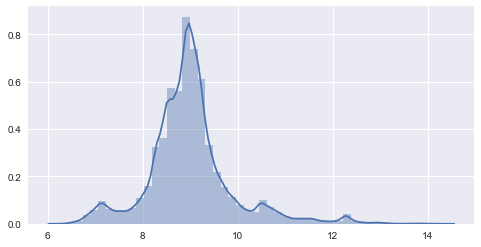

In [16]:
df_new = df_new.withColumn( 'log_sqft_lot', log('sqft_lot') )
sn.distplot(df_new.select('log_sqft_lot').toPandas(), norm_hist=True)

Checking corelation after normal distribution

In [17]:
df_new.stat.corr( 'price', 'sqft_lot' )

0.0896608605871003

In [18]:
df_new.stat.corr( 'log_price', 'log_sqft_lot' )

0.13772713692112706

# Age of house can be the good parameter which can influence price of house.
# So while looking at information provided we will assume that 2015 as base year and calculate the age and renovate age.

In [19]:
df_new = df_new.withColumn("age", lit(2015) - col('yr_built'))
df_new = df_new.withColumn("rennovate_age", lit(2015) - col('yr_renovated'))

In [20]:
# keeping a copy of dataframe for further use
df_orignal = df_new

# Feature columns and their type

In [21]:
continuous_features = ['sqft_living', 'bedrooms', 'bathrooms', 'floors',
                    'log_sqft_lot', 'age', 'sqft_above',
                    'sqft_living15', 'sqft_lot15', 'rennovate_age']

categorical_features = ['zipcode', 'waterfront',
                      'grade', 'condition',
                      'view']

# Creating function to convert categorical variable using one hot encoder

In [22]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, PolynomialExpansion, VectorIndexer

def create_category_vars( dataset, field_name ):
    idx_col = field_name + "Index"
    col_vec = field_name + "Vec"
    
    month_stringIndexer = StringIndexer( inputCol=field_name,
                                     outputCol=idx_col )
    month_model = month_stringIndexer.fit( dataset )
    month_indexed = month_model.transform( dataset )
    
    month_encoder = OneHotEncoder( dropLast=True,
                               inputCol=idx_col,
                               outputCol= col_vec )
    
    return month_encoder.transform( month_indexed )


for col in categorical_features:
    df_new = create_category_vars( df_new, col )

df_new.cache()

DataFrame[id: bigint, date: string, price: double, bedrooms: int, bathrooms: double, sqft_living: int, sqft_lot: int, floors: double, waterfront: int, view: int, condition: int, grade: int, sqft_above: int, sqft_basement: int, yr_built: int, yr_renovated: int, zipcode: int, lat: double, long: double, sqft_living15: int, sqft_lot15: int, log_price: double, log_sqft_lot: double, age: int, rennovate_age: int, zipcodeIndex: double, zipcodeVec: vector, waterfrontIndex: double, waterfrontVec: vector, gradeIndex: double, gradeVec: vector, conditionIndex: double, conditionVec: vector, viewIndex: double, viewVec: vector]

# Final feature columns

In [23]:
feature_columns = continuous_features + ['zipcodeVec', 'waterfrontVec', 'gradeVec', 'conditionVec', 'viewVec']

# Model Building using spark ml lib

In [24]:
# preparing dataframe for model building

assembler = VectorAssembler( inputCols = feature_columns, outputCol = "features")
assembler.outputCol

df_model = assembler.transform( df_new )

In [25]:
from pyspark.sql.functions import round

df_model = df_model.withColumn( "label", round('log_price', 4) )

# Splitting train and test data

In [26]:
train_df, test_df = df_model.randomSplit( [0.7, 0.3], seed = 42 )

# Linier Regression

In [27]:
from pyspark.ml.regression import LinearRegression

linreg = LinearRegression(maxIter=500, regParam=0.0)

lm = linreg.fit( train_df )
lm.intercept

12.704784581962699

In [28]:
from pyspark.sql.functions import exp
from pyspark.ml.evaluation import RegressionEvaluator

y_pred = lm.transform( test_df )
y_pred = y_pred.withColumn( "y_pred", exp( 'prediction' ) )

# function for getting r-square and rmse values

In [29]:
def get_r2_rmse( model, test_df ):
    y_pred = model.transform( test_df )
    y_pred = y_pred.withColumn( "y_pred", exp( 'prediction' ) )
    rmse_evaluator = RegressionEvaluator(labelCol="price", predictionCol="y_pred", metricName="rmse" )
    r2_evaluator = RegressionEvaluator(labelCol="price", predictionCol="y_pred", metricName="r2" )
    return [np.round( r2_evaluator.evaluate( y_pred ), 2), np.round( rmse_evaluator.evaluate( y_pred ), 2 )]

In [30]:
perf_params = get_r2_rmse( lm, test_df )
perf_params

[0.88, 127519.31]

# Creating a evaluvation dataframe for comparision of different models

In [31]:
import pandas as pd

model_perf = pd.DataFrame( columns = ['name', 'rsquared', 'rmse'] )

model_perf = model_perf.append( pd.Series( ["Linear Regression"] + perf_params ,
                 index = model_perf.columns ),
                 ignore_index = True )
model_perf

,name,rsquared,rmse
0,Linear Regression,0.88,127519.31


# Grid Search for Optimal Regularization Parameter using Spark ML tuning

In [32]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

lrModel  =  LinearRegression(maxIter=50)

paramGrid = ParamGridBuilder().addGrid(lrModel.regParam, [0.1, 0.01, 0.001]).addGrid(lrModel.elasticNetParam, [0.0]).build()

evaluator = RegressionEvaluator(metricName="r2",labelCol="label",)

crossval = CrossValidator(estimator=lrModel, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=2)

cvModel = crossval.fit( train_df )

# Find the best parameters

In [33]:
cvModel.bestModel._java_obj.getRegParam()

0.001

In [34]:
cvModel.bestModel._java_obj.getElasticNetParam()

0.0

# Ridge Regression

In [35]:
ridge_perf = get_r2_rmse( cvModel.bestModel, test_df )

model_perf = model_perf.append( pd.Series( ["Ridge Regression"] + ridge_perf , index = model_perf.columns ),
                               ignore_index = True )

model_perf

,name,rsquared,rmse
0,Linear Regression,0.88,127519.31
1,Ridge Regression,0.87,132052.04


# Using Lasso Regression

the regParam is a L1 (ridge) penalty, if elastic param is 1.0

In [36]:
paramGrid = ParamGridBuilder().addGrid(lrModel.regParam, [0.1, 0.01, 0.001]).addGrid(lrModel.elasticNetParam, [1.0]).build()

evaluator = RegressionEvaluator(metricName="r2", labelCol="label",)

crossval = CrossValidator(estimator=lrModel,
                        estimatorParamMaps=paramGrid,
                        evaluator=evaluator,
                        numFolds=2)

In [37]:
cvModel = crossval.fit( train_df )
cvModel.bestModel._java_obj.getElasticNetParam()

1.0

In [38]:
cvModel.bestModel._java_obj.getRegParam()

0.001

In [39]:
lasso_perf = get_r2_rmse( cvModel.bestModel, test_df )

In [40]:
model_perf = model_perf.append( pd.Series( ["Lasso Regression"] + lasso_perf ,
                 index = model_perf.columns ),
                 ignore_index = True )

model_perf

,name,rsquared,rmse
0,Linear Regression,0.88,127519.31
1,Ridge Regression,0.87,132052.04
2,Lasso Regression,0.85,142393.73


# Function to create best model using Grid parameters and Cross Validation Strategy

In [41]:
def getBestModel( paramGrid, lModel, train, test ):
    evaluator = RegressionEvaluator(
      metricName="r2",
      labelCol="label",
  )
    crossval = CrossValidator(estimator=lModel,
                        estimatorParamMaps=paramGrid,
                        evaluator=evaluator,
                        numFolds=2)  # use 3+ folds in practice
    cvModel = crossval.fit( train )
    r2, rmse = get_r2_rmse( cvModel.bestModel, test )
    
    print( "RMSE: ", np.round( rmse, 2 ) )
    print( "R-Squared: ", np.round( r2, 2 ) )
    
    return cvModel, rmse, r2

In [42]:
lModel = LinearRegression(maxIter=50)

enetParamGrid = ParamGridBuilder().addGrid(lModel.regParam, [0.1, 0.01]).addGrid(lModel.elasticNetParam, [0.2, 0.5]).build()

train_df, test_df = df_model.randomSplit( [0.7, 0.3], seed = 42 )

In [43]:
enetModel, rmse, r2 = getBestModel( enetParamGrid,
                                 lModel,
                                 train_df,
                                 test_df )

('RMSE: ', 140636.55)
('R-Squared: ', 0.85)


In [44]:
enet_perf = get_r2_rmse( enetModel.bestModel, test_df )

In [45]:

model_perf  = model_perf.append( pd.Series( ["ElasticNet Regression"] + enet_perf ,
                 index = model_perf.columns ),
                 ignore_index = True )

model_perf

,name,rsquared,rmse
0,Linear Regression,0.88,127519.31
1,Ridge Regression,0.87,132052.04
2,Lasso Regression,0.85,142393.73
3,ElasticNet Regression,0.85,140636.55


# Decision Tree Regressor

Using a decision tree regressor with maxdept = 6

In [46]:
from pyspark.ml.regression import DecisionTreeRegressor, RandomForestRegressor

treeModel = DecisionTreeRegressor(featuresCol="features",
                              labelCol="label",
                              maxDepth=6)

tlm = treeModel.fit( train_df )

tree_perf = get_r2_rmse( tlm, test_df )

model_perf = model_perf.append( pd.Series( ["Decistion Tree"] + tree_perf ,
                 index = model_perf.columns ),
                 ignore_index = True )

model_perf

,name,rsquared,rmse
0,Linear Regression,0.88,127519.31
1,Ridge Regression,0.87,132052.04
2,Lasso Regression,0.85,142393.73
3,ElasticNet Regression,0.85,140636.55
4,Decistion Tree,0.66,214901.42


# Random Forest Regressor

In [47]:
rfModel = RandomForestRegressor(featuresCol="features",
                              labelCol="label",
                              numTrees=100,
                              maxDepth=10,
                              featureSubsetStrategy='onethird')


rflm  =  rfModel.fit(train_df  )

rf_perf = get_r2_rmse( rflm, test_df )

model_perf = model_perf.append( pd.Series( ["Random Forest Tree"] + rf_perf ,
                 index = model_perf.columns ),
                 ignore_index = True )

model_perf

,name,rsquared,rmse
0,Linear Regression,0.88,127519.31
1,Ridge Regression,0.87,132052.04
2,Lasso Regression,0.85,142393.73
3,ElasticNet Regression,0.85,140636.55
4,Decistion Tree,0.66,214901.42
5,Random Forest Tree,0.75,183712.90


# Conclusion

The best model performance is Linear Regression with .88 R-Squared value and minimum RMSE Values.